# New k-mer extension that happens more globally
Make it run faster.

Steps:
1. Index the database 
2. Build a hash table of the masses of all b+, b++, y+, and y++ ions and masses
3. Search for all sequences that get mass hits
4. Filter the results
5. Attempt aligments


In [102]:
# -*- coding: latin-1 -*-
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.types.database import Database
from src.types.objects import Spectrum
from src.file_io import fasta
from modules.sequence_generation import proteins, peptides
from src.spectra.gen_spectra import gen_spectrum
from src.scoring.scoring import score_subsequence

import math
from collections import namedtuple, defaultdict, deque
import time
import bisect
from operator import itemgetter
from typing import Iterable, Any
import regex as re


## Utils

In [3]:
def insort_by_key(value: Any, a: Iterable, key: str) -> Iterable:
    '''
    Insert value into list in order. List a given should be sorted prior to insort
    
    Inputs:
        value:    (Any) thing to be inserted
        a:        (Iterable) the list or list-like value to insert into
        key:      (str) the key to use for comparison of two values
    Ouputs:
        Iterable a with value inserted in order by key
    '''
    if len(a) == 0:
        return [value]
    elif len(a) == 1:
        return a + [value] if getattr(a[0], key) <= getattr(value, key) else [value] + a
    
    mid = math.floor(len(a)/2)
    if getattr(a[mid-1], key) <= getattr(value, key) <= getattr(a[mid], key):
        return a[:mid] + [value] + a[mid:]
    elif getattr(a[mid], key) > getattr(value, key):
        return insort_by_key(value, a[:mid], key) + a[mid:]
    else:
        return a[:mid] + insort_by_key(value, a[mid:], key)

In [4]:
def insort_by_index(value: Any, a: Iterable, index: int) -> Iterable:
    '''
    Insert value into list in order. List a given should be sorted prior to insort
    
    Inputs:
        value:    (Any) thing to be inserted
        a:        (Iterable) the list or list-like value to insert into
        index:    (int) the index to use for comparison of two values
    Ouputs:
        Iterable a with value inserted in order by index
    '''
    if len(a) == 0:
        return [value]
    elif len(a) == 1:
        return a + [value] if a[0][index] <= value[index] else [value] + a
    
    mid = math.floor(len(a)/2)
    if a[mid-1][index] <= value[index] <= a[mid][index]:
        return a[:mid] + [value] + a[mid:]
    elif a[mid][index] > value[index]:
        return insort_by_index(value, a[:mid], index) + a[mid:]
    else:
        return a[:mid] + insort_by_index(value, a[mid:], index)

In [93]:
from statistics import mean

def slope_filtering(a: Iterable, min_window_size=5, mean_filter=1) -> list:
    '''
    Filter out values by slope. Use a window size of at least min_window_size and at max 1% the size of 
    iterable a. Result is the subset of results whose window mean > mean_filter*mean_slope
    
    Inputs:
        a:     (Iterable) the list or list like object to filter
    kwargs:
        min_window_size:    (int) the minimum window size to use for sliding means. Default=5
        mean_filter:        (int) a scaling factor to determine what values pass. This value
                                  is mutliplied by the mean slope and values > than this are accepted. Default=1
    Outputs:
        list with the filtered results
    '''
    adjusted_window_size = len(a) // 100
    window_size = min_window_size if adjusted_window_size < min_window_size else adjusted_window_size
    slopes = [(a[i+window_size] - a[i])/window_size for i in range(len(a) - window_size)]
    avgslope = mean(slopes)
    filtered = []
    for i in range(len(slopes)):
        if abs(slopes[i]) > abs(avgslope):
            filtered.append(a[i])
        else:
            break
    return filtered

In [109]:
from itertools import product

def all_LI(s: str) -> list:
    '''
    Find all permutations of a string that has values 'L' or 'I' in them
    
    Inputs:
        s:    (str) the string to evaluate
    Outputs:
        list of all the permutations of 'L' and 'I'
    '''
    keyletters = 'LI'

    # Convert input string into a list so we can easily substitute letters
    seq = list(s)
    
    perms = []

    # Find indices of key letters in seq
    indices = [ i for i, c in enumerate(seq) if c in keyletters ]

    # Generate key letter combinations & place them into the list
    for t in product(keyletters, repeat=len(indices)):
        for i, c in zip(indices, t):
            seq[i] = c
        perms.append(''.join(seq))
    return perms


## Global extension and addition

In [6]:

MassSequence = namedtuple('MassSequence', ['mass', 'sequence'])

def ppm_to_da(observed: float, ppm_tolerance: float) -> float:
    '''
    Calculate the absolute boundary value from an observed mass. Value returned is in Da
    
    Inputs:
        observed:      (float) the observed mass used to calculate the tolerances
        ppm_tolerance: (float or int) the tolerance in ppm to use to convert to Da
    Outputs:
        float value in Da 
    '''
    return abs((ppm_tolerance / 1000000)*observed)


def search_kmers_hash(observed: Spectrum, kmers: dict, tolerance: float) -> list:
    '''
    Search through all of the base kmers and find those that gave us good hits
    
    Inputs:
        spectrum:    (Spectrum) what to sequence
        allbasemers: (dict of list of MassSequence) all of the basemers made from the function 'make_all_base_mers_hash'
        tolerance:   (float) the ppm tolerance to accept for each mass
    Outputs:
        list of MassSequence for all masses that were in the acceptable range of an observed mass
    '''
    hits = []
    for mass in observed.spectrum:
        tol = ppm_to_da(mass, tolerance)
        lb_mass = mass - tol
        ub_mass = mass + tol
        lb_mass_key = math.floor(lb_mass)
        ub_mass_key = math.floor(ub_mass)
        hits += [x.sequence for x in kmers[ub_mass_key] if lb_mass <= x.mass <= ub_mass]
        if lb_mass_key != ub_mass_key:
            hits += [x.sequence for x in kmers[ub_mass_key] if lb_mass <= x.mass <= ub_mass]
            
    return hits

## Build a dictionary for sizes min length to max length

In [7]:
KmerMasses = namedtuple('KmerMasses', ['bs', 'bd', 'ys', 'yd'])

def build_kmermasses(database: Database, min_peptide_len: int, max_peptide_len: int) -> KmerMasses:
    '''
    Build a KmerMasses object from a database. The entries to the KmerMasses object 
    are dictionaries where keys are integer values of masses and the entries are lists of MassSequence objects
    
    Inputs: 
        database:          (Database) object used for reading in proteins, creating the tree, and indexing
        min_peptide_len:   (int) the minimum length peptide to consider. NOTE: this is also the minimum length 
                                 any protein can contribute to a hybrid peptide. 
                                 Example:
                                     protein 1: ABCDEFGHIJK, protein 2: LMNOPQRSTUV
                                     true hybrid sequence: IJK-LMNOPQ
                                     min_peptide_len should be set to 3
        max_peptide_len:   (int) the maximum peptide length to consider
    Outputs:
        KmerMasses object
    '''
    bs = defaultdict(list)
    bd = defaultdict(list)
    ys = defaultdict(list)
    yd = defaultdict(list)
    
    kmer_tracker = defaultdict(str)
    
    print(f'Indexing database for k={max_peptide_len}...')
    database.set_kmer_size(max_peptide_len)
    database.index()
    print('Done')
    mdl = len(database.metadata.keys())
    
    printskiplen = mdl // 1000
    printskipc = 0
    
    for i, kmer in enumerate(list(database.metadata.keys())):
        if len(kmer) < min_peptide_len: 
            continue
            
        if printskipc == printskiplen:
            print(f'Looking at kmer {i + 1}/{mdl}\r', end='')
            printskipc = 0
            
        printskipc += 1
        
        kmerspecbs = gen_spectrum(kmer, ion='b', charge=1)['spectrum']
        kmerspecbd = gen_spectrum(kmer, ion='b', charge=2)['spectrum']
        kmerspecys = gen_spectrum(kmer, ion='y', charge=1)['spectrum']
        kmerspecyd = gen_spectrum(kmer, ion='y', charge=2)['spectrum']
        
        for i in range(min_peptide_len, len(kmer)):
            subseq_b = kmer[:i]
            subseq_y = kmer[len(kmer)-i-1:]
            
            if 'b' not in kmer_tracker[subseq_b]:
                kmer_tracker[subseq_b] += 'b'
        
                bs[math.floor(kmerspecbs[i-1])].append(MassSequence(kmerspecbs[i-1], subseq_b))
                bd[math.floor(kmerspecbd[i-1])].append(MassSequence(kmerspecbd[i-1], subseq_b))
            
            if 'y' not in kmer_tracker[subseq_y]:
                kmer_tracker[subseq_y] += 'y'
            
                ys[math.floor(kmerspecys[i-1])].append(MassSequence(kmerspecys[i-1], subseq_y))
                yd[math.floor(kmerspecyd[i-1])].append(MassSequence(kmerspecyd[i-1], subseq_y))
                    
    del kmer_tracker
        
    return KmerMasses(bs, bd, ys, yd)

## Create an alignment from the sequences

In [8]:
def align_overlaps(seq1: str, seq2: str) -> str:
    '''
    Attempt to align two string sequences. It will look at the right side of seq1 and left side of seq2
    to overlap the two strings. If no overlap is found, seq2 is appended to seq1
    
    Inputs:
        seq1:    (str) the left side sequence 
        seq2:    (str) the right side sequence
    Outputs:
        str the attempted alignments
    '''
    alignment = None
    # if we have a perfect overlap, return it
    if seq1 == seq2:
        alignment = seq1
    
    # if one is a full subsequence of another, return the larger one
    elif seq1 in seq2:
        p and print('seq1 in seq2')
        alignment = seq2
    elif seq2 in seq1:
        p and print('seq2 in seq1')
        alignment = seq1
    
    else:
        # try and find an alignment. seq2 should overlap as much of the right of seq1 as possible
        start_points = [i for i in range(len(seq1)) if seq2[0] == seq1[i]]
        for sp in start_points:
            # try and see if extending it makes it match
            for i in range(sp, len(seq1)):
                if seq1[i] != seq2[i-sp]:
                    i -= 1
                    break
            if i == len(seq1) - 1:
                s2_start = len(seq1) - sp
                right_seq = seq2[s2_start] if s2_start < len(seq2) else ''
                alignment = seq1 + seq2[s2_start:]
                break
            else:
                alignment = seq1 + seq2
    return alignment
            

In [9]:
def hybrid_alignment(seq1: str, seq2: str) -> (str, str):
    '''
    Create a hybrid alignment from 2 sequences. If an overlap between these two sequences
    is found, () are placed around the ambiguous section. 
    Example:
        seq1: ABCDE, seq2: DEFGH
        attempted alignment: ABC(DE)FGH
    If there is no overlap, then seq2 is appended to seq1 with a - at the junction
    Example:
        seq1: ABCD, seq2: EFGH
        attempted alignment: ABCD-EFGH
        
    Inputs:
        seq1:    (str) the left sequence
        seq2:    (str) the right sequence
    '''
    alignment = ''
    hybalignment = ''
    attempted_overlap = align_overlaps(seq1, seq2)
    if attempted_overlap is not None and 0 < len(attempted_overlap) < len(seq1) + len(seq2):
        # there is an overlap and some ambiguity
        # get the starting point of seq2
        rightstart = attempted_overlap.index(seq2)
        leftend = len(seq1) - 1
        # range between leftend and rigth start is ambiguous
        middle_sec = attempted_overlap[rightstart:leftend + 1]
        
        alignment = attempted_overlap
        hybalignment = attempted_overlap[:rightstart] + '(' + middle_sec + ')' + attempted_overlap[leftend+1:]
    else:
        alignment = seq1 + seq2
        hybalignment = seq1 + '-' + seq2
        
    return (alignment, hybalignment)

# TESTING

## Generate data

### 1. Load fasta database

In [10]:
fasta_file = '../../testing framework/data/databases/100prots.fasta'
database = fasta.read(fasta_file, True)

database = {x['name']: x for x in database}

### 2.  Generate the peptides, hybrid proteins and peptides

In [11]:
test_directory = '../../testing framework/data/testing_output/'

num_hybs = 5
min_length= 5
max_length = 20
num_peptides = 1000
min_cont = 3 #min contribution for each side of a hybrid

# make hybrid proteins
hyb_prots = proteins.generate_hybrids([x for _, x in database.items()], num_hybs, min_contribution=max_length)
# create peptides
non_hybrid_peps = peptides.gen_peptides([x for _, x in database.items()], num_peptides, min_length=min_length, max_length=max_length, digest='random', dist='beta')
# create hybrid peptides
hyb_peps = peptides.gen_peptides(hyb_prots, num_hybs, min_length=min_length, max_length=max_length, digest='random', min_contribution=min_cont, hybrid_list=True)
print(hyb_peps[0]['hybrid_sequence'])
all_proteins_raw = [x for _,x in database.items()] + hyb_prots
all_peptides_raw = non_hybrid_peps + hyb_peps

peps = {}
for i, pep in enumerate(all_peptides_raw):
    peps[i] = pep
    peps[i]['scan_no'] = i
    

Generating hybrid protein 4/5[80%]
Finished generating hybrid proteins
RRE-LQV


### 3. Generate spectra

In [12]:
spectra = []
sorted_keys = [int(c) for c in peps.keys()]
sorted_keys.sort()
for k in sorted_keys:
    pep = peps[k]
    cont = gen_spectrum(pep['sequence'])
    spec = cont['spectrum']
    pm = cont['precursor_mass']
    spectra.append({'spectrum': spec, 'precursor_mass': pm})


## Run the new kmer extension

### Make the kmer hash table

In [13]:
indexing_st = time.time()

print('Loading database...')
db = Database(fasta_file)
print('\nDone.')

print('Building hashes for kmers...')
kmermasses = build_kmermasses(db, min_cont, max_length)
print(f'\nDone. Time to complete: {time.time() - indexing_st}')


Loading database...
Adding protein 100/100 to tree
Done.
Building hashes for kmers...
Indexing database for k=20...
Done
Looking at kmer 54970/54996
Done. Time to complete: 20.924911975860596


## Search

In [111]:
st = time.time()

hashsearchtime = 0
alignmenttime = 0
resultfilteringtime = 0

hyb_alignment_pattern = re.compile(r'[-\(\)]')

# scoredistb = []
# scoredisty = []

# scoredistbfullseqs = []
# scoredistyfullseqs = []

speclen = len(spectra)
alignments = {}
for i, spec in enumerate(spectra):
    print('On spectrum {}/{}\r'.format(i + 1, speclen), end='')
    hstst = time.time()
    # find all of the basic hits first
    s = Spectrum(spec['spectrum'])
    bs, bd, ys, yd = search_kmers_hash(s, kmermasses.bs, 20), search_kmers_hash(s, kmermasses.bd, 20), search_kmers_hash(s, kmermasses.ys, 20), search_kmers_hash(s, kmermasses.yd, 20)
    results = {
        'bs': bs,
        'bd': bd,
        'ys': ys,
        'yd': yd,
    }
    hashsearchtime += (time.time() - hstst)
    #########################################################################
    #                      BIGGEST TIME TAKER BLOCK
    #########################################################################
    rftst = time.time()
    # narrow down the results to a few promising kmers
    basemerhashedb = defaultdict(list)
    basemerhashedy = defaultdict(list)
    basemerbblacklist = {}
    basemeryblacklist = {}
    b_scores = []
    y_scores = []
    # hash by the base mer (in this case its 3)
    for key, value in results.items():
        if 'b' in key:
            for val in value:
                basemerb = val[:3]
                # check to see if we've seen it
                # skip if its blacklisted
                if basemerb in basemerbblacklist:
                    continue
                # if we've not seen it, try and add it
                if basemerb not in basemerhashedb:
                    basemerbscore = score_subsequence(s.spectrum, basemerb)[0]
                    # blacklist for bad scores
                    if not basemerbscore > 0:
                        basemerbblacklist[basemerb] = None
                        continue
                    # insert in order
                    b_scores = insort_by_index((basemerb, score_subsequence(s.spectrum, basemerb)[0]), b_scores, 1)
                basemerhashedb[basemerb].append(val)
        else:
            for val in value:
                basemery = val[len(val)-3:]
                # check to see if we've seen it
                # skip if its blacklisted
                if basemery in basemeryblacklist:
                    continue
                # if we've not seen it, try and add it
                if basemery not in basemerhashedy:
                    basemeryscore = score_subsequence(s.spectrum, basemery)[1]
                    # blacklist for bad score
                    if not basemeryscore > 0:
                        basemeryblacklist[basemery] = None
                        continue
                    # insert in order
                    y_scores = insort_by_index((basemery, score_subsequence(s.spectrum, basemery)[1]), y_scores, 1)
                basemerhashedy[basemery].append(val)

    # bookkeeping to see what the scores look like
#     scoredistb.append([x[1] for x in b_scores[::-1]])
#     scoredisty.append([x[1] for x in y_scores[::-1]])

    toscoreb = []
    toscorey = []
    
    b_filtered = [b_scores[-1*i - 1] for i in range(len(slope_filtering([x[1] for x in b_scores[::-1]])))]
    y_filtered = [y_scores[-1*i - 1] for i in range(len(slope_filtering([x[1] for x in y_scores[::-1]])))]
    
    if len(b_filtered) < 5:
        b_filtered = b_scores[::-1][:5]
    if len(y_filtered) < 5:
        y_filtered = y_scores[::-1][:5]
    
    # revese to go from highest to lowest
    for basemerb in b_filtered:
        toscoreb += [basemerb[0]] + basemerhashedb[basemerb[0]]
        
    for basemery in y_filtered:
        toscorey += [basemery[0]] + basemerhashedy[basemery[0]]
    
    best_b_results = sorted(toscoreb, key=lambda mer: score_subsequence(s.spectrum, mer)[0], reverse=True)
    best_y_results = sorted(toscorey, key=lambda mer: score_subsequence(s.spectrum, mer)[1], reverse=True)
    resultfilteringtime += time.time() - rftst
    
#     scoredistbfullseqs.append([score_subsequence(s.spectrum, mer)[0] for mer in best_b_results])
#     scoredistyfullseqs.append([score_subsequence(s.spectrum, mer)[1] for mer in best_y_results])
    #########################################################################
    #                      /BIGGEST TIME TAKER BLOCK
    #########################################################################
    atst = time.time()
    # try and create an alignment
    spec_alignments = []
    for bs in best_b_results[:5]:
        bproteins = [id_ for id_, _ in db.tree.find_all(bs)]
        for ys in best_y_results[:5]:
            yproteins = [id_ for id_, _ in db.tree.find_all(ys)]
            
            # the sequence is from the same protein, try and overlap it
            if any([x in yproteins for x in bproteins]):
                spec_alignments.append(align_overlaps(bs, ys))
            # otherwise just concatenate them 
            else: 
#                 spec_alignments.append(bs + '-' + ys)
                spec_alignments.append(hybrid_alignment(bs, ys)[1])
        
    # remove repeats
    a = list(set([x for x in spec_alignments if x is not None]))
    # sort them by their score agains the spectrum and save them
    alignments[i] = sorted(a, key=lambda x: score_subsequence(spectra[i]['spectrum'], x.replace('-', '').replace('(', '').replace(')', '')), reverse=True)[:5]
    
    # replace any hybrid sequences that are found in the database as non hybrids 
    for j in range(len(alignments[i])):
        # look for the hybrid indicator strings
        if hyb_alignment_pattern.findall(alignments[i][j]):
            nonhyb = re.sub(hyb_alignment_pattern, '', alignments[i][j])
            # also try to replace L and I with eachother 
            possible = all_LI(nonhyb)
            if len(possible) == 0 and db.tree.find(nonhyb):
                alignments[i][j] = nonhyb
            else:
                for p in possible:
                    if db.tree.find(p):
                        alignments[i][j] = p
                        break
            
    alignmenttime += time.time() - atst
ttime = time.time() - st
print(f'\nDone. Time to complete: {round(ttime, 2)}s')
print(f'Time breakdown: \
        \nhash search time: {round(hashsearchtime, 2)}s,\t {int(100 * hashsearchtime/ttime)}% \
        \nresults filtering time: {round(resultfilteringtime, 2)}s, \t {int(100 * resultfilteringtime / ttime)}% \
        \nalignment time: {round(alignmenttime, 2)}s, \t{int(100 * alignmenttime/ttime)}%')



On spectrum 1245/1245
Done. Time to complete: 258.66s
Time breakdown:         
hash search time: 36.31s,	 14%         
results filtering time: 218.37s, 	 84%         
alignment time: 3.75s, 	1%


# Check how well it did

In [112]:
hits = 0
misses = 0
hbhits = 0
hbmisses = 0

badones = []
hybridmisses = []
hybridhits = []
for i in range(len(alignments)):
    if not len(alignments[i]):
        print(f'missing alignment at {i}')
        continue
    hits
    if 'hybrid' not in peps[i]['peptide_name'].lower() and alignments[i][0] == peps[i]['sequence']:
        hits += 1
    elif 'hybrid' in peps[i]['peptide_name'].lower() and alignments[i][0].replace('-', '').replace('(', '').replace(')', '') == peps[i]['sequence']:
        hbhits += 1
        hybridhits.append((alignments[i][0], peps[i]['hybrid_sequence']))
    
    # misses
    else: 
        if 'hybrid' in peps[i]['peptide_name'].lower():
            hbmisses += 1
            hybridmisses.append((peps[i]['hybrid_sequence'], alignments[i]))
        else:
            misses += 1
            badones.append((alignments[i][0], peps[i]['sequence']))
#     print('attempted alignment: {} \t actual sequence: {}'.format(alignments[i][0], peps[i]['sequence']))

print(f'Non-hybrid accuracy: {hits}/{hits + misses} [{int(100 * hits / (hits + misses))}%]')
print(f'Hybrid accuracy: {hbhits}/{hbhits + hbmisses} [{int(100 * hbhits / (hbhits + hbmisses))}]%')

Non-hybrid accuracy: 993/1000 [99%]
Hybrid accuracy: 224/245 [91]%


In [113]:
for b in badones:
    print(b)

('TTLLL', 'TTLLI')
('ISL(I)IDLCL', 'ISIIDLCL')
('LSLRR', 'LSIRR')
('GLRLRLLL-RIIL', 'GLRLRLLL')
('IFGLF', 'IFGIF')
('GILFII', 'GIIFLI')
('FGWGAGPIWL-PLIW', 'FGWGAGPIWL')


In [114]:
for hm in hybridmisses:
    print(hm)

('RRE-LQVN', ['RREI-QVN', 'RRE(L)QVN', 'RREL-QVN', 'RRELPVPYLTGMILMG-LQVN', 'RRELPVPYLTGMILMG-VLQVN'])
('RRE-LQVNRDVLD', ['RREI-QVNRDVLD', 'RRE-LQVNRDVLD', 'RREL-QVNRDVLD', 'RRE(L)QVNRDVLD', 'RREI-LQVNRDVLD'])
('IDRRE-LQV', ['IDRRE-IQV', 'IDRR-ELQV', 'IDRR(E)LQV', 'IDRRE-SELQV', 'IDRR-SELQV'])
('AIDRRE-LQV', ['AIDRRE-IQV', 'AIDRR(E)LQV', 'AIDRR-ELQV', 'AIDRRE-SELQV', 'AIDRR-SELQV'])
('VFT-IEC', ['VFT(L)EC', 'VFTL-EIEC', 'VFTL-IEC', 'VFTL-GIEC', 'VFTL-SIEC'])
('VFT-IECY', ['VFTL-ECY', 'VFT-IECY', 'VFTL-DIECY', 'VFTL-IECY', 'VFT-DIECY'])
('VFT-IECYIN', ['VFTL-ECYIN', 'VFT-IECYIN', 'VFTL-IECYIN', 'VFTL-DIECYIN', 'VFT-ECYIN'])
('VFT-IECYINGG', ['VFTL-ECYINGG', 'VFT-IECYINGG', 'VFTL-IECYINGG', 'VFTL-CYINGG', 'VFT-ECYINGG'])
('AVFT-IEC', ['AVFT-LEC', 'AVFT-GIEC', 'AVFT-SIEC', 'AVF-GIEC', 'AVF-LEC'])
('SAVFT-IEC', ['SAVFT-LEC', 'SAVFT-SIEC', 'SAVFT-GIEC', 'SAVF-GIEC', 'SAVF-SIEC'])
('TSAVFT-IEC', ['TSAVFT-LEC', 'TSAVFTVGDNVVSGS-NGKTPLHVACEIANLEC', 'TSAVFTVGDNVVSG(S)IEC', 'TSAVFTVGDNVVSGS-LEC'

## Plot the base 3-mer stuff

In [76]:
import matplotlib.pyplot as plt
import numpy as np

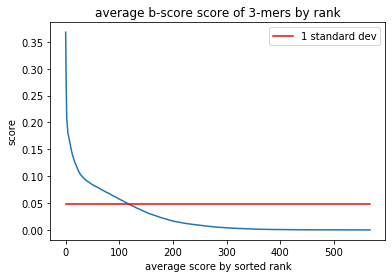

In [77]:
ml = max([len(l) for l in scoredistb])
for i in range(len(scoredistb)):
    scoredistb[i] = scoredistb[i] + [0 for _ in range(ml - len(scoredistb[i]))]
    
avgb = np.mean(scoredistb, axis=0)
stdb = np.std(scoredistb)
plt.plot(avgb)
plt.plot([stdb for _ in range(len(avgb))], 'r', label='1 standard dev')
plt.title('average b-score score of 3-mers by rank')
plt.xlabel('average score by sorted rank')
plt.ylabel('score')
plt.legend()

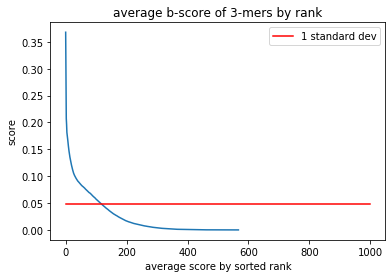

In [78]:
plt.plot(avgb[:1000])
plt.plot([stdb for _ in range(1000)], 'r', label='1 standard dev')
plt.title('average b-score of 3-mers by rank')
plt.xlabel('average score by sorted rank')
plt.ylabel('score')
plt.legend()

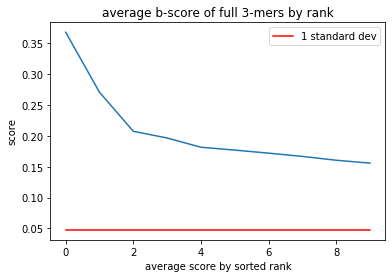

In [79]:
plt.plot(avgb[:10])
plt.plot([stdb for _ in range(10)], 'r', label='1 standard dev')
plt.title('average b-score of full 3-mers by rank')
plt.xlabel('average score by sorted rank')
plt.ylabel('score')
plt.legend()

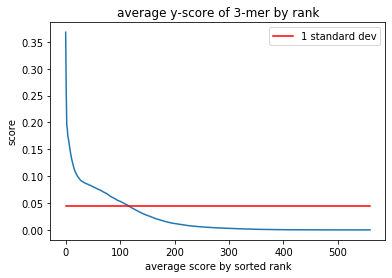

In [80]:
ml = max([len(l) for l in scoredisty])
for i in range(len(scoredisty)):
    scoredisty[i] = scoredisty[i] + [0 for _ in range(ml - len(scoredisty[i]))]
    
avgy = np.mean(scoredisty, axis=0)
stdy = np.std(scoredisty)
plt.plot(avgy)
plt.plot([stdy for _ in range(len(avgy))], 'r', label='1 standard dev')
plt.title('average y-score of 3-mer by rank')
plt.xlabel('average score by sorted rank')
plt.ylabel('score')
plt.legend()

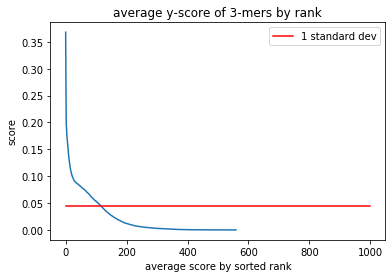

In [81]:
plt.plot(avgy[:1000])
plt.plot([stdy for _ in range(1000)], 'r', label='1 standard dev')
plt.title('average y-score of 3-mers by rank')
plt.xlabel('average score by sorted rank')
plt.ylabel('score')
plt.legend()

average b slope: -0.0004348660809943197


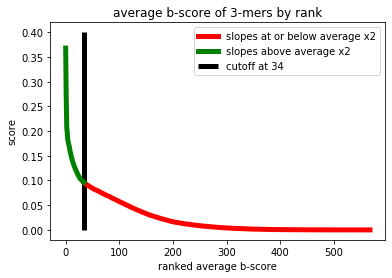

In [88]:
bslopes = [(avgb[i+5] - avgb[i])/5 for i in range(len(avgb) - 5)] 
avgbslope = np.mean(bslopes)
print(f'average b slope: {avgbslope}')
interested = []
for i, bs in enumerate(bslopes):
    if abs(bs) > abs(avgbslope) *2:
        interested.append(avgb[i])
    else:
        break

below_avg = avgb[len(interested):]
plt.plot([i for i in range(len(interested), len(interested) + len(below_avg))], below_avg, 'r', lw=5,label='slopes at or below average x2')
plt.vlines(len(interested)-1, 0, 0.4, colors='k', lw=5, label=f'cutoff at {len(interested)-1}')
plt.plot(interested, 'g', lw=5, label='slopes above average x2')
plt.title('average b-score of 3-mers by rank')
plt.xlabel('ranked average b-score')
plt.ylabel('score')
plt.legend()


## Plot filtered full sequences stuff

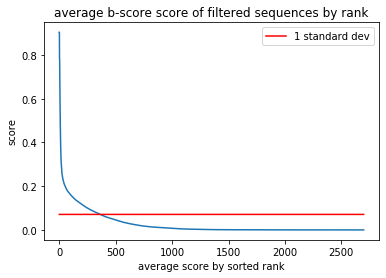

In [85]:
mlfs = max([len(l) for l in scoredistbfullseqs])
for i in range(len(scoredistbfullseqs)):
    scoredistbfullseqs[i] = scoredistbfullseqs[i] + [0 for _ in range(mlfs - len(scoredistbfullseqs[i]))]
    
avgbfs = np.mean(scoredistbfullseqs, axis=0)
stdbfs = np.std(scoredistbfullseqs)
plt.plot(avgbfs)
plt.plot([stdbfs for _ in range(len(avgbfs))], 'r', label='1 standard dev')
plt.title('average b-score score of filtered sequences by rank')
plt.xlabel('average score by sorted rank')
plt.ylabel('score')
plt.legend()

average b slope: -0.00030054246619012204


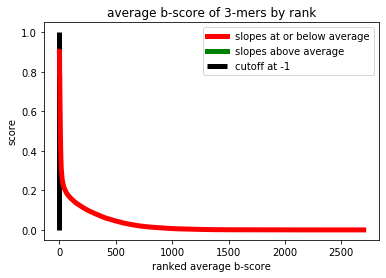

In [86]:
bslopesfs = [(avgbfs[i+5] - avgbfs[i])/5 for i in range(len(avgbfs) - 5)] 
avgbslopefs = np.mean(bslopesfs)
print(f'average b slope: {avgbslopefs}')
interestedfs = []
for i, bs in enumerate(bslopesfs):
    if abs(bs) > abs(avgbslopefs):
        interested.append(avgbfs[i])
    else:
        break

below_avgfs = avgbfs[len(interestedfs):]
plt.plot([i for i in range(len(interestedfs), len(interestedfs) + len(below_avgfs))], below_avgfs, 'r', lw=5,label='slopes at or below average')
plt.vlines(len(interestedfs)-1, 0, 1, colors='k', lw=5, label=f'cutoff at {len(interestedfs)-1}')
plt.plot(interestedfs, 'g', lw=5, label='slopes above average')
plt.title('average b-score of 3-mers by rank')
plt.xlabel('ranked average b-score')
plt.ylabel('score')
plt.legend()


In [116]:
db.tree.find_all('MAL')

[('TECR_MOUSE', <suffix_tree.util.Path at 0x7f87da663a10>),
 ('SDHL_MOUSE', <suffix_tree.util.Path at 0x7f87da679790>),
 ('AT2A3_MOUSE', <suffix_tree.util.Path at 0x7f87dbb33650>),
 ('AT2A2_MOUSE', <suffix_tree.util.Path at 0x7f87dbc0ed50>),
 ('TTC8_MOUSE', <suffix_tree.util.Path at 0x7f87dac97b90>),
 ('CEA15_MOUSE', <suffix_tree.util.Path at 0x7f87dadabc50>),
 ('AGAL_MOUSE', <suffix_tree.util.Path at 0x7f87db5d1d50>),
 ('AGAL_MOUSE', <suffix_tree.util.Path at 0x7f87db631c90>),
 ('CLCN2_MOUSE', <suffix_tree.util.Path at 0x7f87db970610>),
 ('AIG1_MOUSE', <suffix_tree.util.Path at 0x7f87dc425050>),
 ('AOXB_MOUSE', <suffix_tree.util.Path at 0x7f87dc7e2590>),
 ('AT2A3_MOUSE', <suffix_tree.util.Path at 0x7f87dbb3b290>),
 ('CDK1_MOUSE', <suffix_tree.util.Path at 0x7f87dc02a7d0>),
 ('CDK6_MOUSE', <suffix_tree.util.Path at 0x7f87dc2d7cd0>),
 ('CSKP_MOUSE', <suffix_tree.util.Path at 0x7f87dc33d350>),
 ('CLMN_MOUSE', <suffix_tree.util.Path at 0x7f87dc9b2b10>)]